🌍 Entrez la latitude (ex: 46.2) :  45


⚠️ Aucun modèle avec R² = 1 trouvé.


,Z,y_cartesien
16,-18,-3.676805
15,-12,-3.257734
14,-6,-2.861853
0,0,-2.485281
1,5,-2.183821
2,10,-1.891793
3,15,-1.607695
4,20,-1.330168
5,25,-1.057962
6,30,-0.789915


AttributeError: 'NoneType' object has no attribute 'predict'

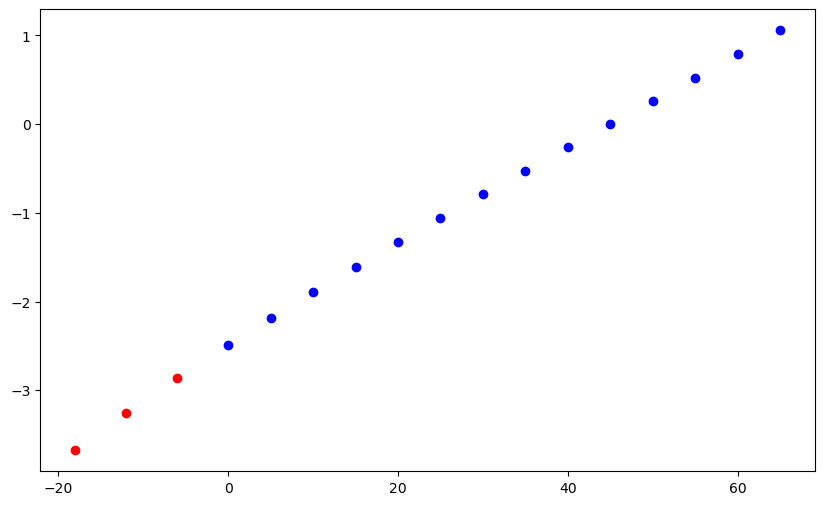

In [1]:
# 📁 Ajout du chemin vers le projet Flask
import sys
import os

chemin_projet = r"C:\Users\admin\Dropbox\00e-NET\0PROJETS\0ASTROLABE\00pythonAstrolabe2"
if chemin_projet not in sys.path:
    sys.path.append(chemin_projet)

# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

from tympan.almucantarats.almucantarats import Almucantarats

# 📥 Demande de la latitude
latitude_input = input("🌍 Entrez la latitude (ex: 46.2) : ")
try:
    latitude = float(latitude_input)
except ValueError:
    print("❌ Latitude invalide.")
    latitude = None

# 🧾 Paramètres
rayon_equateur = 6

if latitude is not None:
    alm = Almucantarats(rayon_equateur, latitude)
    resultats = []

    # ✅ Données réelles (Z = 0 à 65)
    Z_reels = list(range(0, 66 + 1, 5))
    for Z in Z_reels:
        cercle = alm.calculer_almucantarat(Z)
        if cercle:
            y_cartesien = cercle["cy"] - cercle["rayon"]
            resultats.append({
                "Z": Z,
                "y_cartesien": y_cartesien,
                "extrapole": False
            })

    # 📈 Régression : degré minimal avec R² = 1
    df_reel = pd.DataFrame(resultats)
    X = df_reel[["Z"]]
    y = df_reel["y_cartesien"]

    meilleur_modele = None
    meilleure_formule = ""
    meilleur_r2 = 0
    degre_final = None

    for d in range(1, 21):
        model = make_pipeline(PolynomialFeatures(d), LinearRegression())
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        if r2 >= 1.0:
            meilleur_modele = model
            degre_final = d
            meilleur_r2 = r2
            coeffs = model.named_steps['linearregression'].coef_
            intercept = model.named_steps['linearregression'].intercept_
            formule = f"y = {intercept:.6f} " + " ".join(
                [f"+ {coeffs[i]:.6f}·Z^{i}" for i in range(1, len(coeffs))]
            )
            meilleure_formule = formule
            break

    if meilleur_modele is None:
        print("⚠️ Aucun modèle avec R² = 1 trouvé.")
        exit()

    # ✅ Extrapolation pour Z = -6, -12, -18
    Z_extrapoles = [-6, -12, -18]
    for Z_ext in Z_extrapoles:
        cercle = alm.calculer_almucantarat(Z_ext)
        if cercle:
            y_cartesien = cercle["cy"] - cercle["rayon"]
        else:
            y_cartesien = meilleur_modele.predict([[Z_ext]])[0]
        resultats.append({
            "Z": Z_ext,
            "y_cartesien": y_cartesien,
            "extrapole": True
        })

    # 📋 Tableau final
    df_all = pd.DataFrame(resultats).sort_values(by="Z")
    display(df_all[["Z", "y_cartesien"]])

    # 📊 Affichage graphique
    plt.figure(figsize=(10, 6))
    for _, row in df_all.iterrows():
        color = 'red' if row["extrapole"] else 'blue'
        plt.scatter(row["Z"], row["y_cartesien"], color=color)

    Z_plot = pd.DataFrame({"Z": np.linspace(-20, 70, 200)})
    y_plot = meilleur_modele.predict(Z_plot)
    plt.plot(Z_plot["Z"], y_plot, color='green', label='Régression (R² = 1)')

    plt.title("Coordonnées Y cartésiennes des intersections")
    plt.xlabel("Z (hauteur en °)")
    plt.ylabel("y cartésien")
    plt.grid(True)
    plt.legend()

    # ➕ Formule + R² dans le coin haut gauche
    plt.text(0.05, 0.95, meilleure_formule, fontsize=9, transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f"R² = {meilleur_r2:.6f}", fontsize=9, transform=plt.gca().transAxes, verticalalignment='top')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Latitude invalide. Aucun calcul effectué.")
